In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd

from scCustomFunctions import *
from parameters import *

import warnings
warnings.filterwarnings('ignore')

# Load the data

We upload the data with the selection of HVGs and log transformed. The log transformation of the data will make that the PCs do have a less dominant contribution among the genes.

In [2]:
a = loadData(QC_imputed=True,Normalized=True,Log1p=True)

# Raw time integration

In [3]:
X = np.zeros([a.obs.index.astype(int).max()+1,N_PCS])

#Global computation of HVGs and PCs
scp.pp.highly_variable_genes(a,flavor=HVG_METHOD)
remove_highly_variable_genes(a,SKIP_GENES) #Remove genes related with sex or cell cycle
scp.pp.pca(a,n_comps=N_PCS,use_highly_variable=USE_HVGs)

for j,stage in enumerate(a.obs["stage"].unique()[:]):
    
    b = a[a.obs["stage"]==stage,:].copy()
    b.obs["stage"]=b.obs["stage"].astype(str)
    b.obs["sample"]=b.obs["sample"].astype(str)
    
    scp.external.pp.harmony_integrate(b,"sample")
    
    index = b.obs.index.values.astype(int)
    
    #Load data from batch correction    
    X[index,:] = b.obsm["X_pca_harmony"]
    
a.obsm["X_pca_harmony"] = X[a.obs.index.values.astype(int),:]

2021-07-30 15:54:43,982 - harmonypy - INFO - Iteration 1 of 10
2021-07-30 15:54:44,331 - harmonypy - INFO - Iteration 2 of 10
2021-07-30 15:54:44,690 - harmonypy - INFO - Iteration 3 of 10
2021-07-30 15:54:44,858 - harmonypy - INFO - Iteration 4 of 10
2021-07-30 15:54:44,983 - harmonypy - INFO - Converged after 4 iterations
2021-07-30 15:54:45,821 - harmonypy - INFO - Iteration 1 of 10
2021-07-30 15:54:47,094 - harmonypy - INFO - Iteration 2 of 10
2021-07-30 15:54:48,362 - harmonypy - INFO - Iteration 3 of 10
2021-07-30 15:54:49,622 - harmonypy - INFO - Converged after 3 iterations
2021-07-30 15:54:49,731 - harmonypy - INFO - Iteration 1 of 10
2021-07-30 15:54:49,893 - harmonypy - INFO - Iteration 2 of 10
2021-07-30 15:54:50,055 - harmonypy - INFO - Iteration 3 of 10
2021-07-30 15:54:50,182 - harmonypy - INFO - Iteration 4 of 10
2021-07-30 15:54:50,241 - harmonypy - INFO - Converged after 4 iterations
2021-07-30 15:54:51,509 - harmonypy - INFO - Iteration 1 of 10
2021-07-30 15:54:53,31

In [12]:
scp.pp.neighbors(a,n_neighbors=50,use_rep="X_pca_harmony")
umap_seed_with_paga(a,resolution=LOUVAIN_INITIALISATION)
scp.tl.umap(a,init_pos="paga")

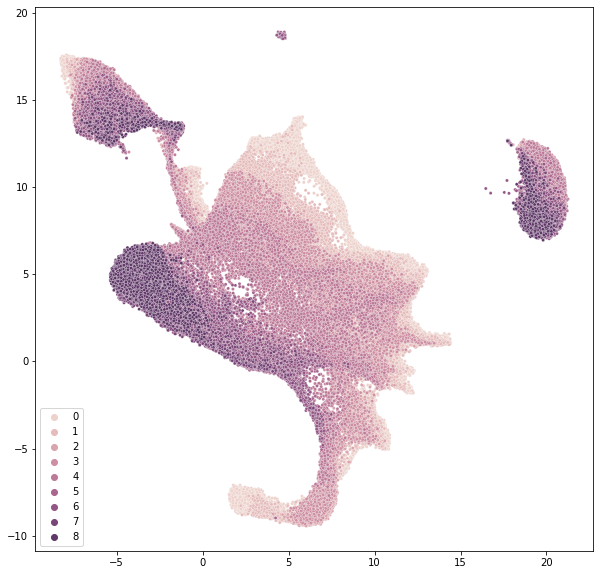

In [13]:
fig,ax=plt.subplots(1,1,figsize=[10,10])

l = ["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]
l.reverse()
for i,stage in enumerate(l):
    sb.scatterplot(a.obsm["X_umap"][a.obs["stage"]==stage,0],a.obsm["X_umap"][a.obs["stage"]==stage,1],hue=i,hue_norm=(0,10),s=10,ax=ax)

In [20]:
scp.tl.paga(a,groups="stage")

In [30]:
a.uns["paga"]["connectivities_tree"].todense()

matrix([[0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.6479162 , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

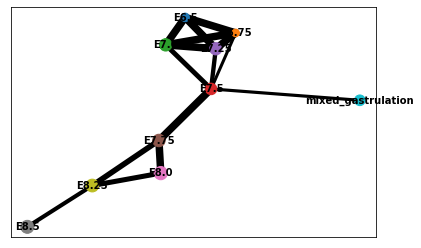

In [38]:
scp.pl.paga(a,threshold=0.4)

In [17]:
scp.tl.draw_graph(a,init="paga")

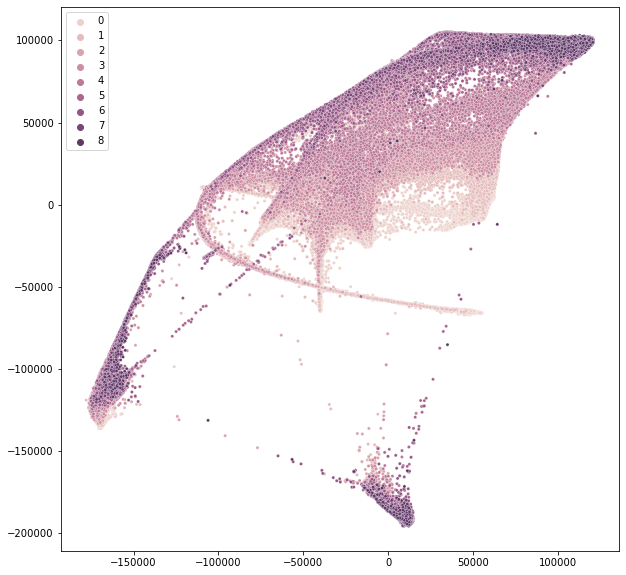

In [18]:
fig,ax=plt.subplots(1,1,figsize=[10,10])

l = ["E6.5","E6.75","E7.0","E7.25","E7.5","E7.75","E8.0","E8.25","E8.5"]
l.reverse()
for i,stage in enumerate(l):
    sb.scatterplot(a.obsm["X_draw_graph_fa"][a.obs["stage"]==stage,0],a.obsm["X_draw_graph_fa"][a.obs["stage"]==stage,1],hue=i,hue_norm=(0,10),s=10,ax=ax)


# Causal connection

# A la Klein

In [4]:
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD

In [5]:
l = (a.obs["stage"]=="E8.5") + (a.obs["stage"]=="E8.25") 
b = a[l,:].copy()

In [6]:
scp.pp.log1p(b)
scp.pp.highly_variable_genes(b,flavor=par.HVG_METHOD)

In [7]:
X = b[b.obs["stage"]=="E8.5",b.var["highly_variable"]].X.copy()
X2 = b[b.obs["stage"]=="E8.25",b.var["highly_variable"]].X.copy()

In [8]:
X_norm = preprocessing.MaxAbsScaler().fit_transform(X)
X2_norm = preprocessing.MaxAbsScaler().fit_transform(X2)

In [9]:
model = TruncatedSVD(n_components=par.N_PCS).fit(X_norm)

In [10]:
X_pca = model.fit_transform(X_norm)
X2_pca = model.fit_transform(X2_norm)

In [11]:
b.obsm["X_pca"] = np.zeros([b.shape[0],par.N_PCS])
b.obsm["X_pca"][b.obs["stage"]=="E8.5",:] = X_pca
b.obsm["X_pca"][b.obs["stage"]=="E8.25",:] = X2_pca

In [12]:
#Make nearest neighbours (1)
scp.pp.neighbors(b,metric=par.METRIC,knn=200,use_rep="X_pca",n_pcs=par.N_PCS)
d = b.obsp["distances"].copy()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 456232 stored elements in Compressed Sparse Row format>

In [13]:
#Cutoff local (2)
maxDistance = 3*(d.power(-1).max(axis=1).power(-1)).toarray()
loc_remove = sp.sparse.csc_matrix((d > maxDistance)).nonzero()
d[loc_remove] = 0
d.eliminate_zeros()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 455744 stored elements in Compressed Sparse Row format>

In [14]:
#Cutoff global (3)
s1 = b.obs["stage"]=="E8.5"
s2 = b.obs["stage"]=="E8.25"

#Remove between samples
mean_across_samples = (d[s1][:,s2].sum()+d[s2][:,s1].sum())/(d[s1][:,s2].data.shape[0]+d[s2][:,s1].data.shape[0])

loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]]))

v = d[loc]
v[d[loc] > mean_across_samples] = 0
d[loc] = v

loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]]))

v = d[loc]
v[d[loc] > mean_across_samples] = 0
d[loc] = v

#Remove within sample
meanDistance = d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0]
stdDistance = np.sqrt(d[s1][:,s1].power(2).sum()/d[s1][:,s1].data.shape[0]-np.power(d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0],2))
maxDistance_s1 = (meanDistance+stdDistance)

meanDistance = d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0]
stdDistance = np.sqrt(d[s2][:,s2].power(2).sum()/d[s2][:,s2].data.shape[0]-np.power(d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0],2))
maxDistance_s2 = (meanDistance+stdDistance)

loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]]))

for i,j in zip(loc[0],loc[1]):
    if d[i,j] > maxDistance_s1:
        d[i,j] = 0
        
loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]])
       ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]]))

for i,j in zip(loc[0],loc[1]):
    if d[i,j] > maxDistance_s2:
        d[i,j] = 0
        
d.eliminate_zeros()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 395284 stored elements in Compressed Sparse Row format>

In [18]:
#Limit to 20 MNN
s1,s2 = d.nonzero()
d[s1,s2] = d[s2,s1]
d.eliminate_zeros()
d

<32588x32588 sparse matrix of type '<class 'numpy.float64'>'
	with 212660 stored elements in Compressed Sparse Row format>

# A la Klein modified

In [4]:
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD

In [5]:
l2 = ['E8.5', 'E8.25', 'E8.0', 'E7.75', 'E7.5', 'E7.25', 'E7.0', 'E6.75']
l1 = ['E8.25', 'E8.0', 'E7.75', 'E7.5', 'E7.25', 'E7.0', 'E6.75', 'E6.5']

In [9]:
data_edges = pd.DataFrame()

for st1,st2 in zip(l1,l2):

    #Extract datasets
    l = (a.obs["stage"]==st1) + (a.obs["stage"]==st2) 
    b = a[l,:].copy()
    
    #Make list of cells for each stage
    s1 = b.obs["stage"]==st2
    s2 = b.obs["stage"]==st1
    
    #Log normalize
    scp.pp.log1p(b)
    
    #Extract HVGs of time i+1
    b2 = b[b.obs["stage"]==st2,:].copy()
    scp.pp.highly_variable_genes(b2,flavor=par.HVG_METHOD)
    hvg = b2.var["highly_variable"].values
    del b2
    
    #Make PCs of time i+1 and project the space of i
    X = b[b.obs["stage"]==st1,hvg].X.copy()
    X2 = b[b.obs["stage"]==st2,hvg].X.copy()

    X_norm = preprocessing.MaxAbsScaler().fit_transform(X)
    X2_norm = preprocessing.MaxAbsScaler().fit_transform(X2)
    
    model = TruncatedSVD(n_components=par.N_PCS).fit(X2_norm) #Fit with the later time point
    
    X_pca = model.transform(X_norm)
    X2_pca = model.transform(X2_norm)
    
    b.obsm["X_pca"] = np.zeros([b.shape[0],par.N_PCS])
    b.obsm["X_pca"][b.obs["stage"]==st1,:] = X_pca
    b.obsm["X_pca"][b.obs["stage"]==st2,:] = X2_pca
    
    #Make neighbours between stages (1)
    scp.external.pp.bbknn(b,"stage",metric=par.METRIC,neighbors_within_batch=10,use_rep="X_pca",n_pcs=par.N_PCS)
    d = b.obsp["distances"].copy()
    
    #Cutoff local (2)
    maxDistance = 3*(d.power(-1).max(axis=1).power(-1)).toarray()
    loc_remove = sp.sparse.csc_matrix((d > maxDistance)).nonzero()
    d[loc_remove] = 0
    d.eliminate_zeros()
    
    #Cutoff global (3)
        #Remove between samples
    mean_across_samples = (d[s1][:,s2].sum()+d[s2][:,s1].sum())/(d[s1][:,s2].data.shape[0]+d[s2][:,s1].data.shape[0])

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s2[j]]))

    v = d[loc]
    v[d[loc] > mean_across_samples] = 0
    d[loc] = v

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s1[j]]))

    v = d[loc]
    v[d[loc] > mean_across_samples] = 0
    d[loc] = v

        #Remove within sample
    meanDistance = d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0]
    stdDistance = np.sqrt(d[s1][:,s1].power(2).sum()/d[s1][:,s1].data.shape[0]-np.power(d[s1][:,s1].sum()/d[s1][:,s1].data.shape[0],2))
    maxDistance_s1 = (meanDistance+stdDistance)

    meanDistance = d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0]
    stdDistance = np.sqrt(d[s2][:,s2].power(2).sum()/d[s2][:,s2].data.shape[0]-np.power(d[s2][:,s2].sum()/d[s2][:,s2].data.shape[0],2))
    maxDistance_s2 = (meanDistance+stdDistance)

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s1[i] and s1[j]]))

    for i,j in zip(loc[0],loc[1]):
        if d[i,j] > maxDistance_s1:
            d[i,j] = 0

    loc = (np.array([i for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]])
           ,np.array([j for i,j in zip(d.nonzero()[0],d.nonzero()[1]) if s2[i] and s2[j]]))

    for i,j in zip(loc[0],loc[1]):
        if d[i,j] > maxDistance_s2:
            d[i,j] = 0

    d.eliminate_zeros()
    
    #Remove excess of neighbours 
    #s1,s2 = d.nonzero()
    #d[s1,s2] = d[s2,s1]
    #d.eliminate_zeros()    
    
    data_edges_aux = pd.DataFrame()
    data_edges_aux["source"] = b.obs.index[d.nonzero()[0]]
    data_edges_aux["target"] = b.obs.index[d.nonzero()[1]]
    data_edges_aux["value"] = d.data
    
    data_edges = data_edges.append(data_edges_aux)

In [10]:
data_edges.to_csv("./ManipulatedData/"+par.METRIC+"/tables/Klein_network_edges.csv")